# Use NMF with Peak Shifting to Fit Multimodal Data
The multi-modal version of our NMF tool attempts to learn the signal for certain components in multiple measurement modalities. 
The objective for the tool is to recreate the original signal by summing up the contributions of each constituents, 
where the contribution is equal to a prototype from each modality multiplied by a "contribution strength" that is specific
to that constituent.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multimodal.keras import (MultiModalFactorizer, run_training,
                              ContinuityRegularizer, MultiRegularizer)
from scipy.interpolate import interp1d
from keras.regularizers import L1L2
from keras.layers import Input
from keras import backend as K
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np
import os

/home/lward/miniconda3/envs/multimodal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lward/miniconda3/envs/multimodal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lward/miniconda3/envs/multimodal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lward/miniconda3/envs/multim

## Load in the Data
It's saved in a pickle file. We only need the diffraction patterns

In [2]:
data = pd.read_pickle(os.path.join('..', 'data.pkl.gz'))

In [3]:
data = data.iloc[:int(data.shape[0] * 0.9)]

Get the XRD pattern below $2\Theta = 10$

In [4]:
xrd_patterns = np.vstack(data['xrd pattern'].apply(lambda x: x[: , 1]))

In [5]:
two_theta = data['xrd pattern'].iloc[0][:, 0]

In [6]:
mask = two_theta < 10.0
two_theta = two_theta[mask]
xrd_patterns = xrd_patterns[:, mask]

In [7]:
xrd_patterns /= xrd_patterns.max()

Get the Raman data

In [8]:
raman_spectrum = np.vstack(data['raman spectrum'].apply(lambda x: x['Intensity'].values))

In [9]:
raman_spectrum /= raman_spectrum.max()

In [10]:
wavenumber = data['raman spectrum'].iloc[0]['Wavelength'].values

## Make the NMF Engine
We are going to use a model with peak shifting and regularization


In [11]:
shift_reg = MultiRegularizer([L1L2(1e-8), ContinuityRegularizer(1e-6, 0)])
contrib_reg = MultiRegularizer([L1L2(1e-5), ContinuityRegularizer(1e-6, 0)])
nmf_layer = MultiModalFactorizer(n_components=8, name='factorization', fit_shift=[True, False], 
                                 component_regularizer=L1L2(l1=1e-6), contribution_regularizer=contrib_reg,
                                 shift_regularizer=shift_reg, subbatch_size=190)


In [12]:
xrd_input = Input(batch_shape=xrd_patterns.shape, name='xrd_signal')
raman_input = Input(batch_shape=raman_spectrum.shape, name='raman_signal')

In [13]:
predicted_signal = nmf_layer([xrd_input, raman_input])

In [14]:
nmf = Model([xrd_input, raman_input], predicted_signal)

Define a loss function to weigh the error in each peak measurement by $1/y_{obs}$, in accordance with the error in the signal

In [15]:
def weighted_loss(y_true, y_pred):
    error = y_true - y_pred
    weight = 1 / y_true
    return K.mean(weight * error ** 2)
nmf.compile('adam', weighted_loss)
nmf.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xrd_signal (InputLayer)         (328, 509)           0                                            
__________________________________________________________________________________________________
raman_signal (InputLayer)       (328, 1340)          0                                            
__________________________________________________________________________________________________
factorization (MultiModalFactor [(328, 509), (328, 1 20040       xrd_signal[0][0]                 
                                                                 raman_signal[0][0]               
Total params: 20,040
Trainable params: 20,040
Non-trainable params: 0
__________________________________________________________________________________________________


In [16]:
%%time
history = run_training(nmf, [xrd_patterns, raman_spectrum], 10000,
                       steps_per_epoch=1,
                       early_stopping_patience=100,
                       early_stopping_tolerance=1e-7,
                       verbose=True)

  0%|                                                                                                                                                                | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




 30%|█████████████████████████████████▎                                                                              | 2971/10000 [1:13:11<2:52:03,  1.47s/it, best_loss=0.00785, loss=0.00785]

Analyze performance

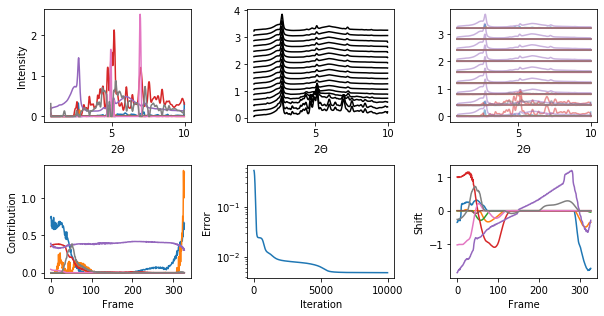

In [17]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

# Get the learned representation
nmf_layer = nmf.get_layer('factorization')
components = nmf_layer.get_components(0)
weights = nmf_layer.get_contributions()
shifted_components = nmf_layer.get_per_sample_contribution(0)
shift_values = K.get_value(nmf_layer.shift[0])

# Plot the components
for comp in components:
    axs[0].plot(two_theta, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
signal_recon = nmf.predict_on_batch([xrd_patterns, raman_spectrum])[0]
for i, row in enumerate(signal_recon):
    if i % 20 != 0: continue
    axs[1].plot(two_theta, row + i / 100, 'k-')
    
# Plot the reconstruction, broken down into components
for comp, c in zip(shifted_components, [f'C{i}' for i in range(shifted_components.shape[0])]):
    for i, row in enumerate(comp):
        if i % 40 != 0: continue
        axs[2].plot(two_theta, row + i / 100, c, zorder=i, alpha=0.5)
    
for ax in axs[:3]:
    ax.set_xlabel('$2 \Theta$')
    
for w in weights.T:
    axs[3].plot(w)
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Contribution')

axs[4].semilogy(history['epoch'], history['loss'])
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Error')

for shift in shift_values.T:
    axs[5].plot(shift)
axs[5].set_xlabel('Frame')
axs[5].set_ylabel('Shift')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()
fig.savefig(os.path.join('multimodal-figures', 'xrd-fit-summary.png'), dpi=320)

*Finding*: **TBD**

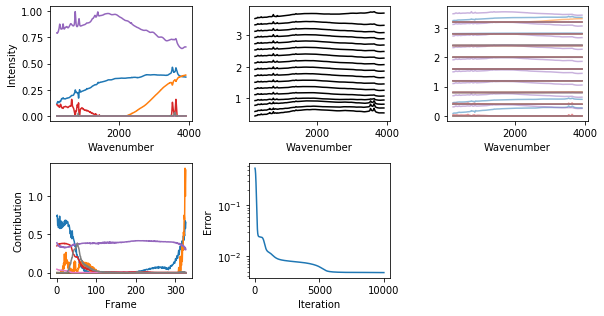

In [18]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

# Get the learned representation
nmf_layer = nmf.get_layer('factorization')
components = nmf_layer.get_components(1)
shifted_components = nmf_layer.get_per_sample_contribution(1)

# Plot the components
for comp in components:
    axs[0].plot(wavenumber, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
signal_recon = nmf.predict_on_batch([xrd_patterns, raman_spectrum])[1]
for i, row in enumerate(signal_recon):
    if i % 20 != 0: continue
    axs[1].plot(wavenumber, row + i / 100, 'k-')
    
# Plot the reconstruction, broken down into components
for comp, c in zip(shifted_components, [f'C{i}' for i in range(shifted_components.shape[0])]):
    for i, row in enumerate(comp):
        if i % 40 != 0: continue
        axs[2].plot(wavenumber, row + i / 100, c, zorder=i, alpha=0.5)
    
for ax in axs[:3]:
    ax.set_xlabel('Wavenumber')
    
for w in weights.T:
    axs[3].plot(w)
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Contribution')

axs[4].semilogy(history['epoch'], history['loss'])
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Error')

axs[5].axis('off')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()
fig.savefig(os.path.join('multimodal-figures', 'raman-fit-summary.png'), dpi=320)

## Save the Pattern
Write out the XRD and Raman data

Save XRD

In [19]:
segment_results = pd.DataFrame({
    'two_theta': two_theta,
})

In [20]:
for i, comp in enumerate(nmf_layer.get_components(0)):
    segment_results[f'component-{i}'] = comp

In [21]:
segment_results.to_csv('xrd-multimodal-segmentations.csv', index=False)

Save Raman

In [22]:
segment_results = pd.DataFrame({
    'wavenumber': wavenumber
})

In [23]:
for i, comp in enumerate(nmf_layer.get_components(1)):
    segment_results[f'component-{i}'] = comp

In [24]:
segment_results.to_csv('raman-multimodal-segmentations.csv', index=False)

### Visualize the Performance
See how good a few patterns look post-reconstruction, if the components make sense, etc

Run the reconstruction

In [25]:
%%time
reconstructed = nmf.predict_on_batch([xrd_patterns, raman_spectrum])[0]

CPU times: user 25.2 s, sys: 348 ms, total: 25.5 s
Wall time: 412 ms


Plot a few

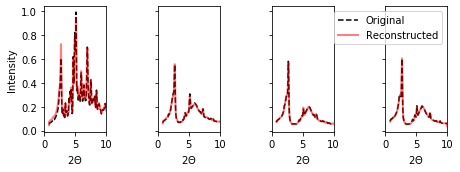

In [26]:
fig, axs = plt.subplots(1, 4, sharey=True)

chosen_ids = np.linspace(0, xrd_patterns.shape[0]-1, 5, dtype=np.int)[:-1]

for pid, ax in zip(chosen_ids, axs):
    ax.set_xlim([0, 10])
    ax.plot(two_theta, xrd_patterns[pid], 'k--', label='Original')
    ax.plot(two_theta, reconstructed[pid], 'r-', label='Reconstructed', alpha=0.5, lw=2)

axs[0].set_ylabel('Intensity')
axs[-1].legend()
for ax in axs:
    ax.set_xlabel('$2\Theta$')
fig.set_size_inches(6.5, 2.5)
fig.tight_layout()

Plot the components

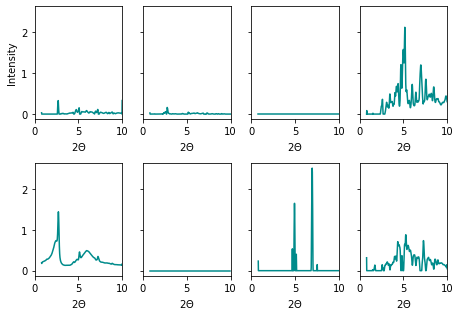

In [27]:
fig, axs = plt.subplots(2, 4, sharey=True)
axs = axs.flatten()

components = nmf_layer.get_components(0)
for pid, ax in enumerate(axs):
    ax.set_xlim([0, 10])
    ax.plot(two_theta, components[pid, :], color='darkcyan')

axs[0].set_ylabel('Intensity')
for ax in axs:
    ax.set_xlabel('$2\Theta$')
fig.set_size_inches(6.5, 4.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'xrd-components.png'), dpi=320)

*Finding*: **TBD**

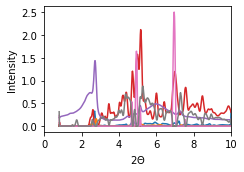

In [28]:
fig, ax = plt.subplots()

for pid in range(components.shape[0]):
    ax.set_xlim([0, 10])
    ax.plot(two_theta, components[pid, :], label=f'{pid}')

ax.set_ylabel('Intensity')
ax.set_xlabel('$2\Theta$')
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('multimodal-figures', 'xrd-components-alltogether.png'), dpi=320)

Plot the change in components

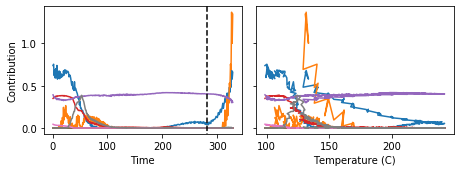

In [29]:
fig, axs = plt.subplots(1, 2, sharey=True)

for i, l in enumerate(weights.T):
    axs[0].plot(data['Seq.'], l, label=i)
axs[0].set_xlabel('Time')
#axs[0].legend()
axs[0].set_ylim(axs[0].get_ylim())
axs[0].plot([data['Seq.'].loc[data['measured temp'].idxmax()]]*2, ax.get_ylim(), 'k--')

axs[1].plot(data['measured temp'], weights)
axs[1].set_xlabel('Temperature (C)')

axs[0].set_ylabel('Contribution')
fig.set_size_inches(6.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('multimodal-figures', 'xrd-proportions.png'), dpi=320)

*Finding*: **TBD**